In [27]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [15]:
hw_bootstrap = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [16]:
hw_bootstrap

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [44]:
hw_bootstrap_control = hw_bootstrap.query('experimentVariant == "Control"').value

In [45]:
hw_bootstrap_treatment = hw_bootstrap.query('experimentVariant == "Treatment"').value

In [ ]:
# сначала - по среднему

In [46]:
boot_it_control_mean = 2000 #сколько делаем бутстрап статистик
boot_data_control_mean = [] #здесь сложим статистики
boot_conf_level_control_mean = 0.95 #уровень значимости, на базе котрого строим доверительный интервал
for i in range(boot_it_control_mean):#вот столько раз итерируемся
    samples = hw_bootstrap_control.sample(len(hw_bootstrap_control), replace = True)
    boot_data_control_mean.append(np.mean(samples)) #итерируемчя по выборке, где считаем среднее

print(f'Original: {np.mean(hw_bootstrap_control)}, Boot: {np.mean(boot_data_control_mean)}')
#оригинальная и бутстрап оценка не очень отличаются по среднему 

Original: 10.026866533804295, Boot: 10.028480990080961


In [47]:
# Найдем доверительный интервал для средних
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_control_mean).quantile([left_ci, right_ci])

print(ci)

0.025     9.943981
0.975    10.112577
dtype: float64


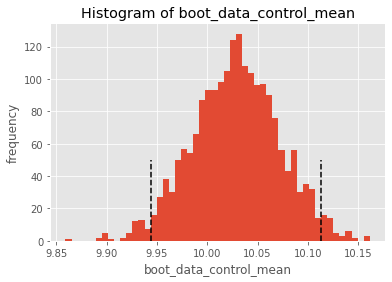

In [48]:
plt.hist(pd.Series(boot_data_control_mean), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data_control_mean')
plt.ylabel('frequency')
plt.title("Histogram of boot_data_control_mean")
plt.show()

In [49]:
boot_it_treatment_mean = 2000 #сколько делаем бутстрап статистик
boot_data_treatment_mean = [] #здесь сложим статистики
boot_conf_level_treatment_mean = 0.95 #уровень значимости, на базе котрого строим доверительный интервал
for i in range(boot_it_treatment_mean):#вот столько раз итерируемся
    samples = hw_bootstrap_treatment.sample(len(hw_bootstrap_treatment), replace = True)
    boot_data_treatment_mean.append(np.mean(samples)) #итерируемчя по выборке, где считаем медиану

print(f'Original: {np.mean(hw_bootstrap_treatment)}, Boot: {np.mean(boot_data_treatment_mean)}')
#оригинальная и бутстрап оценка не очень отличаются по среднему 

Original: 27.321499056661573, Boot: 27.327844806067237


In [50]:
# Найдем доверительный интервал для средних
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_treatment_mean).quantile([left_ci, right_ci])

print(ci)

0.025    13.048955
0.975    44.912247
dtype: float64


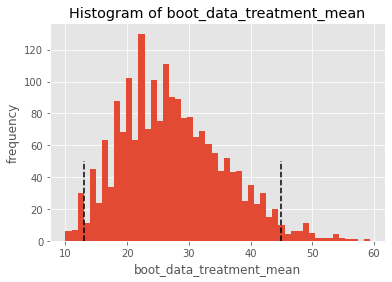

In [51]:
plt.hist(pd.Series(boot_data_treatment_mean), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data_treatment_mean')
plt.ylabel('frequency')
plt.title("Histogram of boot_data_treatment_mean")
plt.show()

In [20]:
#среднее значение тестируемой метрики стало выше
#h0 = этот результат случайный, на самом деле, ничего не изменилось; проверим ее с помощью бутстрапа

In [21]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

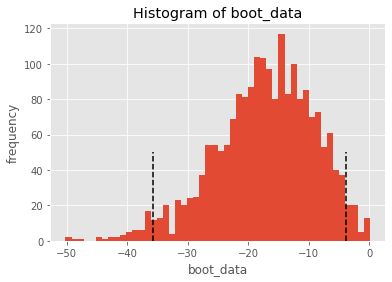

In [52]:
booted_data_mean = get_bootstrap(hw_bootstrap.query('experimentVariant == "Control"').value, hw_bootstrap.query('experimentVariant == "Treatment"').value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [53]:
booted_data_mean["p_value"]
#отклоняем нулевую гипотезу, изменения значимы, вывод здесь - можем раскатывать на все

0.0347684244195572

In [54]:
booted_data_mean["ci"]
#доверительный интервал не попадает в 0, значит, нулевую гипотезу отклоняем, вывод - можно раскатывать на все

,0
0.025,-35.810110
0.975,-3.895152


In [ ]:
#теперь - с помощью критерия Манна-Уитни
#ho = нет значимой разницы между распределениями

In [57]:
mannwhitneyu(hw_bootstrap_control, hw_bootstrap_treatment)
#pvalue > 0.05, в данном случае мы принимаем нулевую гипотезу о том, что нет значимой разницы между распределениями

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [ ]:
#считаем по медиане

In [61]:
boot_it_control_median = 2000 #сколько делаем бутстрап статистик
boot_data_control_median = [] #здесь сложим статистики
boot_conf_level_control_median = 0.95 #уровень значимости, на базе котрого строим доверительный интервал
for i in range(boot_it_control_median):#вот столько раз итерируемся
    samples = hw_bootstrap_control.sample(len(hw_bootstrap_control), replace = True)
    boot_data_control_median.append(np.median(samples)) #итерируемчя по выборке, где считаем медиану

print(f'Original: {np.median(hw_bootstrap_control)}, Boot: {np.mean(boot_data_control_median)}')
#оригинальная и бутстрап оценка не очень отличаются по медиане 

Original: 10.0184651909296, Boot: 10.026140802572234


In [59]:
# Найдем доверительный интервал для средних
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_control_median).quantile([left_ci, right_ci])

print(ci)

0.025     9.930011
0.975    10.116905
dtype: float64


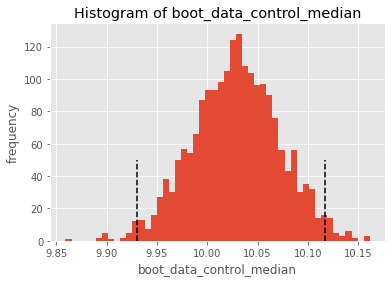

In [60]:
plt.hist(pd.Series(boot_data_control_mean), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data_control_median')
plt.ylabel('frequency')
plt.title("Histogram of boot_data_control_median")
plt.show()

In [62]:
boot_it_treatment_median = 2000 #сколько делаем бутстрап статистик
boot_data_treatment_median = [] #здесь сложим статистики
boot_conf_level_treatment_median = 0.95 #уровень значимости, на базе котрого строим доверительный интервал
for i in range(boot_it_treatment_median):#вот столько раз итерируемся
    samples = hw_bootstrap_treatment.sample(len(hw_bootstrap_treatment), replace = True)
    boot_data_treatment_median.append(np.median(samples)) #итерируемчя по выборке, где считаем медиану

print(f'Original: {np.median(hw_bootstrap_treatment)}, Boot: {np.mean(boot_data_treatment_median)}')
#оригинальная и бутстрап оценка не очень отличаются по медиане 

Original: 10.02584684253515, Boot: 10.031311738675335


In [63]:
# Найдем доверительный интервал для средних
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(boot_data_treatment_median).quantile([left_ci, right_ci])

print(ci)

0.025     9.934214
0.975    10.117803
dtype: float64


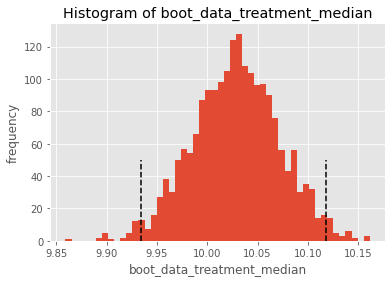

In [64]:
plt.hist(pd.Series(boot_data_control_mean), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data_treatment_median')
plt.ylabel('frequency')
plt.title("Histogram of boot_data_treatment_median")
plt.show()

In [ ]:
#медианеое значение тестируемой метрики стало выше
#h0 = этот результат случайный, на самом деле, ничего не изменилось; проверим ее с помощью бутстрапа

In [65]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

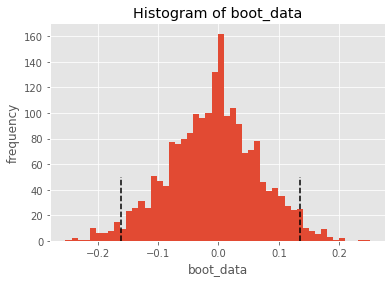

In [66]:
booted_data_median = get_bootstrap_median(hw_bootstrap.query('experimentVariant == "Control"').value, hw_bootstrap.query('experimentVariant == "Treatment"').value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [67]:
booted_data_median["p_value"]
#не отклоняем нулевую гипотезу, изменения не значимы, вывод здесь - нельзя раскатывать на все

0.9441887067514652

In [69]:
booted_data_median["ci"]
#доверительный интервал попадает в 0, значит, нулевую гипотезу неотклоняем, вывод - нельзя раскатывать на все

,0
0.025,-0.161684
0.975,0.134837


In [ ]:
#посмотрим на распредления наших данных

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  6.,  2.,
         8.,  5.,  7., 15., 13., 13., 17., 14., 20., 19., 22., 30., 29.,
        33., 29., 35., 30., 15., 22., 19., 17., 11., 15., 10.,  8.,  7.,
         5.,  4.,  2.,  2.,  3.,  2.,  2.,  3.,  1.,  0.,  1.]),
 array([ 6.43654076,  6.57041686,  6.70429296,  6.83816906,  6.97204516,
         7.10592126,  7.23979736,  7.37367345,  7.50754955,  7.64142565,
         7.77530175,  7.90917785,  8.04305395,  8.17693005,  8.31080615,
         8.44468225,  8.57855835,  8.71243445,  8.84631055,  8.98018665,
         9.11406275,  9.24793885,  9.38181495,  9.51569104,  9.64956714,
         9.78344324,  9.91731934, 10.05119544, 10.18507154, 10.31894764,
        10.45282374, 10.58669984, 10.72057594, 10.85445204, 10.98832814,
        11.12220424, 11.25608034, 11.38995644, 11.52383254, 11.65770864,
        11.79158473, 11.92546083, 12.05933693, 12.19321303, 12.32708913,
        12.46096523, 12.59484133, 12.72871743, 12.86259353,

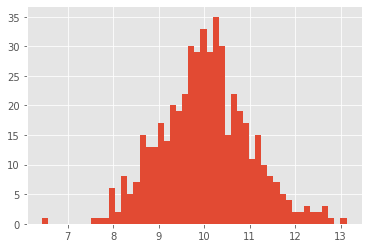

In [70]:
plt.hist(hw_bootstrap_control, bins = 50)

(array([495.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([   6.43654076,   66.30780994,  126.17907913,  186.05034831,
         245.9216175 ,  305.79288668,  365.66415587,  425.53542505,
         485.40669424,  545.27796342,  605.14923261,  665.02050179,
         724.89177098,  784.76304016,  844.63430935,  904.50557853,
         964.37684772, 1024.2481169 , 1084.11938609, 1143.99065527,
        1203.86192446, 1263.73319364, 1323.60446282, 1383.47573201,
        1443.34700119, 1503.21827038, 1563.08953956, 1622.96080875,
        1682.83207793, 1742.70334712, 1802.5746163 , 1862.44588549,
        1922.31715467, 1982.18842386, 2042.05969304, 2101.93096223,
        2161.80223141, 2221.6735006 , 2281.544

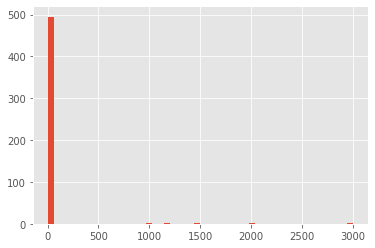

In [72]:
plt.hist(hw_bootstrap_treatment, bins = 50)

In [ ]:
#проблема - в распределении тестовых наблюдений, они крайне сильно скошены вправо, практически все расположены около нуля, но присутствуют сильные выбросы, которые и сместили нам средний показатель в тестовой выборке
#это значит, что среднее значение очень сильно сдвинулось, и мы не можем опираться на результаты нашей самой первой проверки: бутстрап средних
#общий вывод - результат эксперимента не позволяет нам сказать, что изменения значимы